# MyAnimeList Data

**Group partners' names:**

- Soumeng Chea
- Fay Feghali
- Erina Kitamura
- Kristine Umeh

## Task Complete:

Below are the list that as a group have completed so far since the project proposal was due.

- Data pre-processing: Completed
- Linear Regression: Completed
- K-nearest neighbors: Completed
- Squares and Cosine Similarity w/ KNN: Almost complete
- K-Mean Cluster w/ PCs: Almost Complete

## To-Do List: From now until the 18th:

- Apriori
- Analyze Results
- Work on PowerPoint
- Prep for Video presentation
- Project report writeup

## **Below are the works that we have done so far**

## Data Pre-Processing 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from statistics import mean
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
data = './datasets/anime_data.csv'

In [3]:
df = pd.read_csv(data)

In [4]:
df.head(5)

,mal_id,aired_from,aired_to,duration,episodes,genres,popularity,premiered,rank,rating,score,scored_by,source,status,studios,synopsis,title,title_english,type
0,1,1998-04-03T00:00:00+00:00,1999-04-24T00:00:00+00:00,24 min per ep,26,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...",38,Spring 1998,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Finished Airing,"[{'mal_id': 14, 'name': 'Sunrise'}]","In the year 2071, humanity has colonized sever...",Cowboy Bebop,Cowboy Bebop,TV
1,100,2001-04-04T00:00:00+00:00,2001-06-27T00:00:00+00:00,23 min per ep,13,"['Comedy', 'Drama', 'Fantasy', 'Magic', 'Roman...",2075,Spring 2001,2703.0,PG-13 - Teens 13 or older,7.21,23787,Manga,Finished Airing,"[{'mal_id': 34, 'name': 'Hal Film Maker'}]","Due to her father's remarriage, robust 16-year...",Shin Shirayuki-hime Densetsu Prétear,Prétear: The New Legend of Snow White,TV
2,1000,1978-03-14T00:00:00+00:00,1979-02-13T00:00:00+00:00,25 min per ep,42,"['Action', 'Sci-Fi', 'Adventure', 'Space', 'Dr...",2980,Spring 1978,1008.0,PG-13 - Teens 13 or older,7.71,7059,Manga,Finished Airing,"[{'mal_id': 18, 'name': 'Toei Animation'}]",It is 2977 AD and mankind has become stagnant....,Uchuu Kaizoku Captain Herlock,Space Pirate Captain Harlock,TV
3,10003,2008-01-01T00:00:00+00:00,NaN,2 min per ep,15,"['Comedy', 'Dementia', 'Horror', 'Seinen']",6848,NaN,10146.0,R+ - Mild Nudity,5.05,1181,Original,Finished Airing,[],"In these jokey short films, many of them crude...",Kago Shintarou Anime Sakuhin Shuu,NaN,OVA
4,10005,2007-03-31T00:00:00+00:00,NaN,1 hr 35 min,1,"['Action', 'Adventure', 'Mecha', 'Sci-Fi']",10765,NaN,6121.0,G - All Ages,6.43,228,Unknown,Finished Airing,"[{'mal_id': 455, 'name': 'Palm Studio'}]",This theatrical version based on the manga by ...,Tetsujin 28-gou: Hakuchuu no Zangetsu,NaN,Movie


### Extracting studio sequences into a new columns

Source: https://stackoverflow.com/questions/71432733/pandas-extracting-a-phrase-in-a-dict-column?noredirect=1#comment126259925_71432733

In case of the items in the column is just string, convert the column into actual object

In [5]:
df['studios'] = df['studios'].apply(ast.literal_eval)

Implementing .str to access indexes/keys from the lists/dicts of items in a column, and use a combination of pipe and where to fallback to the original values where the result from .str to returns NaN

In [6]:
df['studios'] = df['studios'].str[0].str['name'].pipe(lambda x: x.where(x.notna(), df['studios']))
df.head(5)

,mal_id,aired_from,aired_to,duration,episodes,genres,popularity,premiered,rank,rating,score,scored_by,source,status,studios,synopsis,title,title_english,type
0,1,1998-04-03T00:00:00+00:00,1999-04-24T00:00:00+00:00,24 min per ep,26,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...",38,Spring 1998,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Finished Airing,Sunrise,"In the year 2071, humanity has colonized sever...",Cowboy Bebop,Cowboy Bebop,TV
1,100,2001-04-04T00:00:00+00:00,2001-06-27T00:00:00+00:00,23 min per ep,13,"['Comedy', 'Drama', 'Fantasy', 'Magic', 'Roman...",2075,Spring 2001,2703.0,PG-13 - Teens 13 or older,7.21,23787,Manga,Finished Airing,Hal Film Maker,"Due to her father's remarriage, robust 16-year...",Shin Shirayuki-hime Densetsu Prétear,Prétear: The New Legend of Snow White,TV
2,1000,1978-03-14T00:00:00+00:00,1979-02-13T00:00:00+00:00,25 min per ep,42,"['Action', 'Sci-Fi', 'Adventure', 'Space', 'Dr...",2980,Spring 1978,1008.0,PG-13 - Teens 13 or older,7.71,7059,Manga,Finished Airing,Toei Animation,It is 2977 AD and mankind has become stagnant....,Uchuu Kaizoku Captain Herlock,Space Pirate Captain Harlock,TV
3,10003,2008-01-01T00:00:00+00:00,NaN,2 min per ep,15,"['Comedy', 'Dementia', 'Horror', 'Seinen']",6848,NaN,10146.0,R+ - Mild Nudity,5.05,1181,Original,Finished Airing,[],"In these jokey short films, many of them crude...",Kago Shintarou Anime Sakuhin Shuu,NaN,OVA
4,10005,2007-03-31T00:00:00+00:00,NaN,1 hr 35 min,1,"['Action', 'Adventure', 'Mecha', 'Sci-Fi']",10765,NaN,6121.0,G - All Ages,6.43,228,Unknown,Finished Airing,Palm Studio,This theatrical version based on the manga by ...,Tetsujin 28-gou: Hakuchuu no Zangetsu,NaN,Movie


### Extract genre list into an individual row

In [7]:
df['genres'].head(5)

0    ['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...
1    ['Comedy', 'Drama', 'Fantasy', 'Magic', 'Roman...
2    ['Action', 'Sci-Fi', 'Adventure', 'Space', 'Dr...
3           ['Comedy', 'Dementia', 'Horror', 'Seinen']
4           ['Action', 'Adventure', 'Mecha', 'Sci-Fi']
Name: genres, dtype: object

**Convert the values in the genres column to actual list, because it might just look like a list but actually be a string.**

In [8]:
df['genres'] = df['genres'].apply(ast.literal_eval)

**Implementing .explode() for genres column**

In [9]:
data = df.explode('genres').reset_index(drop = True)

In [10]:
data.head(5)

,mal_id,aired_from,aired_to,duration,episodes,genres,popularity,premiered,rank,rating,score,scored_by,source,status,studios,synopsis,title,title_english,type
0,1,1998-04-03T00:00:00+00:00,1999-04-24T00:00:00+00:00,24 min per ep,26,Action,38,Spring 1998,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Finished Airing,Sunrise,"In the year 2071, humanity has colonized sever...",Cowboy Bebop,Cowboy Bebop,TV
1,1,1998-04-03T00:00:00+00:00,1999-04-24T00:00:00+00:00,24 min per ep,26,Adventure,38,Spring 1998,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Finished Airing,Sunrise,"In the year 2071, humanity has colonized sever...",Cowboy Bebop,Cowboy Bebop,TV
2,1,1998-04-03T00:00:00+00:00,1999-04-24T00:00:00+00:00,24 min per ep,26,Comedy,38,Spring 1998,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Finished Airing,Sunrise,"In the year 2071, humanity has colonized sever...",Cowboy Bebop,Cowboy Bebop,TV
3,1,1998-04-03T00:00:00+00:00,1999-04-24T00:00:00+00:00,24 min per ep,26,Drama,38,Spring 1998,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Finished Airing,Sunrise,"In the year 2071, humanity has colonized sever...",Cowboy Bebop,Cowboy Bebop,TV
4,1,1998-04-03T00:00:00+00:00,1999-04-24T00:00:00+00:00,24 min per ep,26,Sci-Fi,38,Spring 1998,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Finished Airing,Sunrise,"In the year 2071, humanity has colonized sever...",Cowboy Bebop,Cowboy Bebop,TV


### Data Information + Rows and Columns

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35984 entries, 0 to 35983
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mal_id         35984 non-null  int64  
 1   aired_from     35977 non-null  object 
 2   aired_to       20657 non-null  object 
 3   duration       35984 non-null  object 
 4   episodes       35984 non-null  int64  
 5   genres         35969 non-null  object 
 6   popularity     35984 non-null  int64  
 7   premiered      13621 non-null  object 
 8   rank           33954 non-null  float64
 9   rating         35984 non-null  object 
 10  score          35984 non-null  float64
 11  scored_by      35984 non-null  int64  
 12  source         35984 non-null  object 
 13  status         35984 non-null  object 
 14  studios        35984 non-null  object 
 15  synopsis       35465 non-null  object 
 16  title          35984 non-null  object 
 17  title_english  19120 non-null  object 
 18  type  

In [12]:
data.shape

(35984, 19)

### Looking for missing value within the dataset

In [13]:
data.isnull().sum()

mal_id               0
aired_from           7
aired_to         15327
duration             0
episodes             0
genres              15
popularity           0
premiered        22363
rank              2030
rating               0
score                0
scored_by            0
source               0
status               0
studios              0
synopsis           519
title                0
title_english    16864
type                 0
dtype: int64

### Extracting Season and Year from primier column to create two new columns

In [14]:
data[['premiered_season', 'premiered_year']] = data['premiered'].str.split(expand = True)

In [15]:
data.head(5)

,mal_id,aired_from,aired_to,duration,episodes,genres,popularity,premiered,rank,rating,...,scored_by,source,status,studios,synopsis,title,title_english,type,premiered_season,premiered_year
0,1,1998-04-03T00:00:00+00:00,1999-04-24T00:00:00+00:00,24 min per ep,26,Action,38,Spring 1998,27.0,R - 17+ (violence & profanity),...,544987,Original,Finished Airing,Sunrise,"In the year 2071, humanity has colonized sever...",Cowboy Bebop,Cowboy Bebop,TV,Spring,1998
1,1,1998-04-03T00:00:00+00:00,1999-04-24T00:00:00+00:00,24 min per ep,26,Adventure,38,Spring 1998,27.0,R - 17+ (violence & profanity),...,544987,Original,Finished Airing,Sunrise,"In the year 2071, humanity has colonized sever...",Cowboy Bebop,Cowboy Bebop,TV,Spring,1998
2,1,1998-04-03T00:00:00+00:00,1999-04-24T00:00:00+00:00,24 min per ep,26,Comedy,38,Spring 1998,27.0,R - 17+ (violence & profanity),...,544987,Original,Finished Airing,Sunrise,"In the year 2071, humanity has colonized sever...",Cowboy Bebop,Cowboy Bebop,TV,Spring,1998
3,1,1998-04-03T00:00:00+00:00,1999-04-24T00:00:00+00:00,24 min per ep,26,Drama,38,Spring 1998,27.0,R - 17+ (violence & profanity),...,544987,Original,Finished Airing,Sunrise,"In the year 2071, humanity has colonized sever...",Cowboy Bebop,Cowboy Bebop,TV,Spring,1998
4,1,1998-04-03T00:00:00+00:00,1999-04-24T00:00:00+00:00,24 min per ep,26,Sci-Fi,38,Spring 1998,27.0,R - 17+ (violence & profanity),...,544987,Original,Finished Airing,Sunrise,"In the year 2071, humanity has colonized sever...",Cowboy Bebop,Cowboy Bebop,TV,Spring,1998


In [16]:
data.columns

Index(['mal_id', 'aired_from', 'aired_to', 'duration', 'episodes', 'genres',
       'popularity', 'premiered', 'rank', 'rating', 'score', 'scored_by',
       'source', 'status', 'studios', 'synopsis', 'title', 'title_english',
       'type', 'premiered_season', 'premiered_year'],
      dtype='object')

### Dropping Columns

In [17]:
data.drop(['mal_id', 'aired_from', 'aired_to', 'synopsis', 'status'], axis = 1, inplace = True)

In [18]:
data.head(5)

,duration,episodes,genres,popularity,premiered,rank,rating,score,scored_by,source,studios,title,title_english,type,premiered_season,premiered_year
0,24 min per ep,26,Action,38,Spring 1998,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,Cowboy Bebop,TV,Spring,1998
1,24 min per ep,26,Adventure,38,Spring 1998,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,Cowboy Bebop,TV,Spring,1998
2,24 min per ep,26,Comedy,38,Spring 1998,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,Cowboy Bebop,TV,Spring,1998
3,24 min per ep,26,Drama,38,Spring 1998,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,Cowboy Bebop,TV,Spring,1998
4,24 min per ep,26,Sci-Fi,38,Spring 1998,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,Cowboy Bebop,TV,Spring,1998


#### Drop primiered column

In [19]:
data.drop(['premiered'], axis = 1, inplace = True)

In [20]:
data.head(5)

,duration,episodes,genres,popularity,rank,rating,score,scored_by,source,studios,title,title_english,type,premiered_season,premiered_year
0,24 min per ep,26,Action,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,Cowboy Bebop,TV,Spring,1998
1,24 min per ep,26,Adventure,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,Cowboy Bebop,TV,Spring,1998
2,24 min per ep,26,Comedy,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,Cowboy Bebop,TV,Spring,1998
3,24 min per ep,26,Drama,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,Cowboy Bebop,TV,Spring,1998
4,24 min per ep,26,Sci-Fi,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,Cowboy Bebop,TV,Spring,1998


#### Drop English title column

In [21]:
data.drop(['title_english'], axis = 1, inplace = True)

In [22]:
data.head(5)

,duration,episodes,genres,popularity,rank,rating,score,scored_by,source,studios,title,type,premiered_season,premiered_year
0,24 min per ep,26,Action,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,TV,Spring,1998
1,24 min per ep,26,Adventure,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,TV,Spring,1998
2,24 min per ep,26,Comedy,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,TV,Spring,1998
3,24 min per ep,26,Drama,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,TV,Spring,1998
4,24 min per ep,26,Sci-Fi,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,TV,Spring,1998


### Fill NaN with 0 or make the empty column as string

In [23]:
data['rank'] = data['rank'].fillna(data['rank'].dropna().mode().values[0])
data['premiered_year'] = data['premiered_year'].fillna(data['premiered_year'].dropna().mode().values[0])
data['genres'].fillna('', inplace = True)
data['premiered_season'].fillna('', inplace = True)
data.isnull().sum()

duration            0
episodes            0
genres              0
popularity          0
rank                0
rating              0
score               0
scored_by           0
source              0
studios             0
title               0
type                0
premiered_season    0
premiered_year      0
dtype: int64

In [24]:
data.head(3)

,duration,episodes,genres,popularity,rank,rating,score,scored_by,source,studios,title,type,premiered_season,premiered_year
0,24 min per ep,26,Action,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,TV,Spring,1998
1,24 min per ep,26,Adventure,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,TV,Spring,1998
2,24 min per ep,26,Comedy,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,TV,Spring,1998


### Preprocess User Datat ###

Following are the code used to preprocess the user_score_data.csv which is originally derived from user_data.csv. This section was commented out and data was exported into a csv since it takes a while to execute.

In [25]:
# user_df = pd.read_csv('./datasets/user_data.csv')
# user_df.insert(0, 'user_id', range(1, 1 + len(user_df)))
# user_watched = user_df[['user_id', 'watched']]

# import ast
# user_data = []

# for i in range(len(user_df)):
#     row = user_watched.iloc[i].watched
#     row = row.strip('][').split('}, ')
#     for item in row:
#         row_dict = {}
#         if (item[-1] != "}"):
#             item = item + "}"
#         item_dict = ast.literal_eval(item)
#         row_dict['user_id'] = user_watched.iloc[i].user_id
#         row_dict['mal_id'] = item_dict['mal_id']
#         row_dict['rating'] = item_dict['score']
#         user_data.append(row_dict)

# df_user_data = pd.DataFrame(user_data)
# df_user_data.to_csv('user_score_data')

### Linear Regression ###

In [26]:
user_data_df = pd.read_csv('./datasets/user_score_data.csv', usecols=['user_id', 'mal_id', 'rating'], dtype={'user_id':'int32', 'mal_id':'int32', 'rating':'float32'})
animes_df = pd.read_csv('./datasets/anime_data.csv', usecols=['mal_id', 'title'], dtype={'mal_id':'int32', 'title':'string'})

Not all users will rate every anime. Therefore, there are missing data in the ratings of animes. To have a better prediction, linear regression can be used to generate predictions of missing data based on existing values.

In [27]:
def getOverallUserAvgAnimeRating(user_data_df):
    average = user_data_df.groupby('mal_id')['rating'].agg('mean')
    return pd.DataFrame({'mal_id':average.index, 'rating':average.values})

In [28]:
def getTestTrainData(y):
    test_data = y[y['rating_y'].isna()]
    train_data = y.dropna(subset=['rating_y'])

    y_train = train_data['rating_y']
    X_train = train_data.drop('rating_y', axis=1)
    
    return test_data, train_data, y_train, X_train

In [29]:
def fillMissingRatingDataLinReg(y):
    test_data, train_data, y_train, X_train = getTestTrainData(y)
    lin_model = LinearRegression().fit(X_train, y_train)
    
    X_test = test_data.drop('rating_y', axis=1)
    y_pred = lin_model.predict(X_test)
    
    test_data.loc[test_data.rating_y.isna(), 'rating_y'] = y_pred
    
    new = pd.concat([test_data, train_data], axis=0).sort_values(by=['mal_id'], ascending=True)
    new.rename(columns={'rating_y':'rating'}, inplace=True)
    
    return new

In [30]:
def getComprehensiveUserRating(user_data_df, user_id):
    '''
        Takes user data and fills missing data based on linear regression
        using collaborative average anime rating. Predicts what user of specified
        id will rate each anime.
    '''
    # get average anime rating
    avg_df = getOverallUserAvgAnimeRating(user_data_df)
    
    # get all user rating
    y = (user_data_df[user_data_df['user_id'] == user_id])
    y = y.drop(columns=['user_id'])
    
    merged_y = pd.merge(avg_df, y, on='mal_id',how='left').drop(columns=['rating_x'])
    
    comprehensive_df = fillMissingRatingDataLinReg(merged_y)
    
    return comprehensive_df

In [31]:
# new = getComprehensiveUserRating(user_data_df, 1)

### K-Nearest Neighbors ###

K-nearest neighbors can be used to generate recommendation based on specified anime. Using collaborative filtering, k-nearest neighbors will search for what other animes were enjoyed by other users who also enjoyed watching the specified anime.

In [32]:
pip install fuzzywuzzy

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [33]:
animes_users = user_data_df.pivot(index='mal_id', columns='user_id', values='rating').fillna(0)
animes_users_mat = csr_matrix(animes_users.values)

In [34]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
model_knn.fit(animes_users_mat)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [35]:
def getRecommendations(movie_title, data_matrix, animes_df, model_knn, n_recommendations):
    model_knn.fit(data_matrix)
    anime_index = process.extractOne(movie_title, animes_df['title'])[2]
    distances, indices = model_knn.kneighbors(data_matrix[anime_index], n_neighbors=n_recommendations)
    for i in indices:
        print(animes_df['title'][i].where(i != anime_index))
    

In [36]:
getRecommendations('Bleach', animes_users_mat, animes_df, model_knn, 5)

3990                                                 <NA>
6198    Iizuka-senpai x Blazer: Ane Kyun! yori The Ani...
5435                              Kanashimi no Belladonna
3093    New Mobile Report Gundam Wing: Frozen Teardrop...
3295                                       Plastic Little
Name: title, dtype: string


### K-Mean CLustering w/ PCA

#### Testing dataset

In [37]:
copy_data = data

In [38]:
copy_data.head()

,duration,episodes,genres,popularity,rank,rating,score,scored_by,source,studios,title,type,premiered_season,premiered_year
0,24 min per ep,26,Action,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,TV,Spring,1998
1,24 min per ep,26,Adventure,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,TV,Spring,1998
2,24 min per ep,26,Comedy,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,TV,Spring,1998
3,24 min per ep,26,Drama,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,TV,Spring,1998
4,24 min per ep,26,Sci-Fi,38,27.0,R - 17+ (violence & profanity),8.79,544987,Original,Sunrise,Cowboy Bebop,TV,Spring,1998


In [39]:
copy_data.drop(['duration', 'genres', 'rating', 'source', 'studios', 'type', 'premiered_season', 'title'], axis = 1, inplace = True)

In [40]:
copy_data.head(3)

,episodes,popularity,rank,score,scored_by,premiered_year
0,26,38,27.0,8.79,544987,1998
1,26,38,27.0,8.79,544987,1998
2,26,38,27.0,8.79,544987,1998


In [41]:
pca = PCA()
pca.fit(copy_data)

PCA()

Text(0, 0.5, 'Explained Variance')

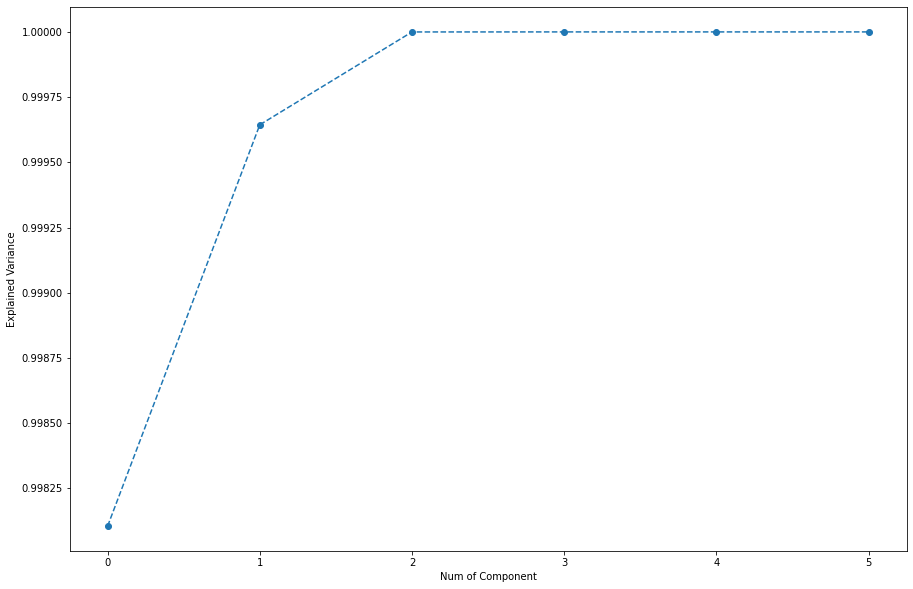

In [42]:
pca.explained_variance_ratio_
plt.figure(figsize = (15, 10))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('Num of Component')
plt.ylabel('Explained Variance')

In [43]:
pcs = PCA(n_components = 2)
pca.fit(copy_data)

PCA()

In [44]:
pca.transform(copy_data)

array([[ 5.11544369e+05,  2.92291512e+03, -1.28216085e+03,
        -5.43023240e+00, -1.43926906e+01, -4.88849352e-01],
       [ 5.11544369e+05,  2.92291512e+03, -1.28216085e+03,
        -5.43023240e+00, -1.43926906e+01, -4.88849352e-01],
       [ 5.11544369e+05,  2.92291512e+03, -1.28216085e+03,
        -5.43023240e+00, -1.43926906e+01, -4.88849352e-01],
       ...,
       [-1.22448102e+04, -3.12998707e+03,  6.58169209e+02,
        -1.26516276e+01,  2.44152379e+00,  2.85198061e-02],
       [-1.22448102e+04, -3.12998707e+03,  6.58169209e+02,
        -1.26516276e+01,  2.44152379e+00,  2.85198061e-02],
       [-1.22448102e+04, -3.12998707e+03,  6.58169209e+02,
        -1.26516276e+01,  2.44152379e+00,  2.85198061e-02]])

In [45]:
scores_pca = pca.transform(copy_data)

#### K-Mean clustering with PCA

In [46]:
from sklearn.cluster import KMeans

In [47]:
wcss = []
for i in range(1, 21):
    pca_kmean = KMeans(n_clusters = i, init = 'k-means++', random_state = 10)
    pca_kmean.fit(scores_pca)
    wcss.append(pca_kmean.inertia_)

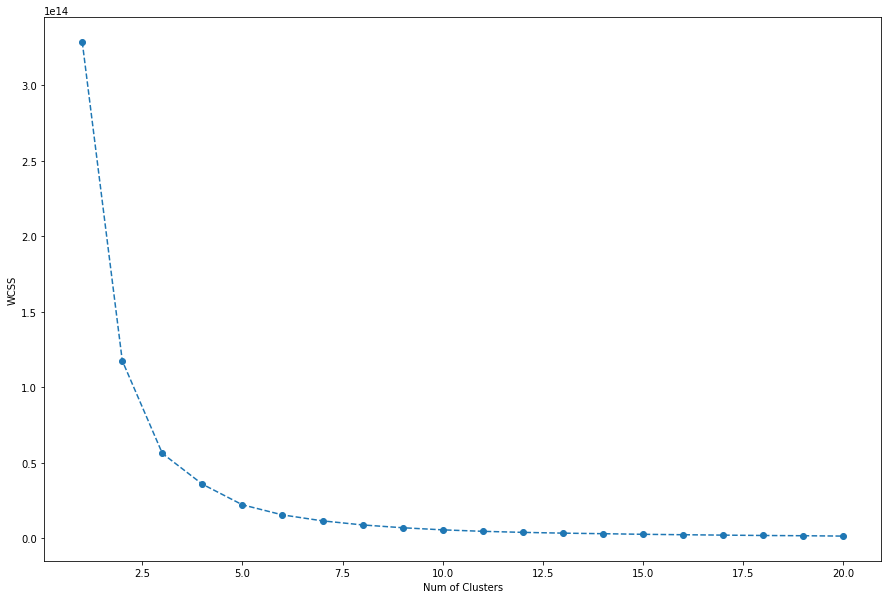

In [55]:
plt.figure(figsize = (15, 10))
plt.plot(range(1, 21), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Num of Clusters')
plt.ylabel('WCSS')
plt.show()

In [56]:
pca_kmeans = KMeans(n_clusters = 3, init = 'k-mean++', random_state = 50)

In [57]:
pca_kmeans.fit(scores_pca)

ValueError: init should be either 'k-means++', 'random', a ndarray or a callable, got 'k-mean++' instead.

In [58]:
data_kmeans = pd.concat([copy_data.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
data_kmeans.head(3)

,episodes,popularity,rank,score,scored_by,premiered_year,0,1,2,3,4,5
0,26,38,27.0,8.79,544987,1998,511544.369229,2922.915125,-1282.16085,-5.430232,-14.392691,-0.488849
1,26,38,27.0,8.79,544987,1998,511544.369229,2922.915125,-1282.16085,-5.430232,-14.392691,-0.488849
2,26,38,27.0,8.79,544987,1998,511544.369229,2922.915125,-1282.16085,-5.430232,-14.392691,-0.488849


## Matrix Factorization - Singular Value Decomposition (SVD)

Followed this tutorial https://towardsdatascience.com/how-did-we-build-book-recommender-systems-in-an-hour-part-2-k-nearest-neighbors-and-matrix-c04b3c2ef55c#:~:text=kNN%20is%20a%20machine%20learning,of%20top%2Dk%20nearest%20neighbors 

In [ ]:
# Imports and process needed datasets
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import sklearn
from sklearn.decomposition import TruncatedSVD

user_rating_data = './datasets/user_score_data.csv'
df = pd.read_csv(user_rating_data)
user_rating_df = df[['user_id', 'mal_id', 'rating']].copy()

anime_info_data = './datasets/anime_data.csv'
anime_df = pd.read_csv(anime_info_data)
columns = ['aired_from', 'aired_to', 'duration', 'episodes', 'genres', 'popularity', 'premiered', 'rank', 'rating', 'score', 'scored_by', 'source', 'status', 'studios', 'synopsis', 'title', 'type']
anime_df = anime_df.drop(columns, axis=1)
anime_df = anime_df.dropna()

### Combine datasets and group by title to get total rating count for each show

In [ ]:
combine_user_anime = pd.merge(user_rating_df, anime_df, on='mal_id')
total_ratings = (combine_user_anime.
                    groupby(by = ['title_english'])['rating'].
                count().
                reset_index().
                rename(columns = {'rating' : 'totalRatingCount'})
                [['title_english', 'totalRatingCount']]
                )
total_ratings.head()

### Narrow the dataset down to anime that have been rated a certain number of times (based on the rating stats)

In [ ]:
userRatings_with_totalRatings = combine_user_anime.merge(total_ratings, left_on='title_english', right_on='title_english')
userRatings_with_totalRatings.head(40)

popularity_threshold = 100 # this can be changed to narrow the scope of our data
ratings_top_anime = userRatings_with_totalRatings.query('totalRatingCount >= @popularity_threshold')
n = len(pd.unique(ratings_top_anime['title_english']))
print("Number of unique anime to be used: ", n)

### Convert to 2D Matrix and transpose

In [ ]:
ratings_top_anime_pivot = ratings_top_anime.pivot_table(index = 'user_id', columns='title_english', values='rating', aggfunc=np.sum).fillna(0)
transposed_ratings = ratings_top_anime_pivot.values.T
ratings_top_anime_pivot.head()

### Run SVD and calculate Pearson R Correlation Coefficient, (need to figure out num of latent variables for later)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category = RuntimeWarning)

# SVD
SVD = TruncatedSVD(n_components=12, random_state=17)
matrix = SVD.fit_transform(transposed_ratings)

# Correlation Coefficient
corr = np.corrcoef(matrix)
corr.shape

### Recommendations based on SVD - Random Choice

In [ ]:
anime_titles = ratings_top_anime_pivot.columns
anime_titles_list = list(anime_titles)

# Pick random anime
title_chosen = np.random.choice(anime_titles_list)
print('Recommendations for: ', title_chosen)  

# Get its index and correlation coefficient
title_index = anime_titles_list.index(title_chosen)
corr_title = corr[title_index]

# List the correlated titles with the random title chosen   
list(anime_titles[(corr_title<1.0) & (corr_title>0.9)])

### Recommendations based on SVD - Input Title

In [ ]:
# Type in title
title_chosen = "Snow White with the Red Hair"
print('Recommendations for: ', title_chosen, '\n')  

# Get its index and correlation coefficient
title_index = anime_titles_list.index(title_chosen)
corr_title = corr[title_index]

# List the correlated titles with the random title chosen   
list(anime_titles[(corr_title<1.0) & (corr_title>0.9)])

**FAY'S TO DO: figure out the right latent variable number, see if we can rank the recommendations list and keep it to 10 recs, see if I can check for accuracy and comparisons for analysis**